In [15]:
# Imports
import pandas as pd
import numpy as np

# ----------- Statistics -------------------- #
from scipy.stats import spearmanr
# Tests
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt

In [13]:
# Functions
# ----------------------- Function for hypothesis testing ---------------------------------- #
def hypothesis_testing(p_value, alpha=0.05):
    ''' 
Prints decision to reject/accept null hypothesis given a significance level and the p-value of the statistical test
    '''
    if p_value < alpha:
        print(f'Given p value = {p_value} is smaller than alpha = {alpha}, the null hypothesis is rejected.')
    else:
        print(f'Given p value = {p_value} is greater than alpha = {alpha}, the null hypothesis fails to be rejected.')

def bootstrapping(data, num_samples):
    '''
    Takes array, number of iterations (means to compute) and returns 95% CI of the mean
    Arguments:
        - Data: np.array
        - CI, number iter
    '''
    bootstrap_means = np.zeros(num_samples)
    for idx_iter in range(num_samples):
        # Sampling from sample
        bootstrap_means[idx_iter] = np.random.choice(data, size=data.size, replace=True).mean()
    
    # np.percentile: computes percentile of data without need to sort
    low_bound = np.percentile(bootstrap_means, 2.5)
    upper_bound = np.percentile(bootstrap_means, 97.5)
    return (low_bound, upper_bound)


In [4]:
# Load TSV file for'paths_unfinished' and 'paths_finished' into a DataFrame
unfinished_paths_column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"]
df_unfinished = pd.read_csv('./dataset/paths_unfinished.tsv',
                             names= unfinished_paths_column_names, sep='\t',
                             comment='#') #ignore metadata


finished_paths_column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
# NULL in 'rating' -> NaN
df_finished = pd.read_csv('./dataset/paths_finished.tsv',
                             names= finished_paths_column_names, sep='\t',
                             comment='#') #ignore metadata


In [5]:
df_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [6]:
df_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


### Correlations between quitting behaviour and features

The column `type` describes the reason for quitting:
- `timeout`: no click made for 30 minutes.
- `restart`: user started a new game without finishing the current one.

**Analysis will focus on "restart"-type quitting**

- `restart`quitting indicates that the user actively decided to start a new game, while `timeout` quitting could occur due to distractions, leaving the game open, or internet issues; hence, it is less indicative of a user’s decision to quit.

In [7]:
# Filter dataset according to restart behaviour

#df_unfinished_t = df_unfinished[df_unfinished['type']=='timeout']
#df_unfinished_r = df_unfinished[df_unfinished['type']=='restart']
# df_unfinished.head()

**Correlation with time at which game began**

In [8]:
# 'Convert Unix timestamps to readable format
df_unfinished['datetime'] = pd.to_datetime(df_unfinished['timestamp'], unit='s')
df_finished['datetime'] = pd.to_datetime(df_finished['timestamp'], unit='s')
# Extract hour
df_unfinished['hour'] = df_unfinished['datetime'].dt.hour
df_finished['hour'] = df_finished['datetime'].dt.hour

In [17]:
# Total games per hour
total_games_per_hour = df_unfinished['hour'].value_counts() + df_finished['hour'].value_counts()

# Proportion of unfinished games by hour
unfinished_counts = df_unfinished['hour'].value_counts()
proportion_unfinished = (unfinished_counts / total_games_per_hour).fillna(0)

# Proportion of finished games by hour
finished_counts = df_finished['hour'].value_counts()
proportion_finished = (finished_counts / total_games_per_hour).fillna(0)

In [19]:
# Prepare data for bootstrapping by creating binary arrays
ci_results = {'hour': [], 'proportion_unfinished': [], 'ci_lower_unfinished': [], 'ci_upper_unfinished': [],
              'proportion_finished': [], 'ci_lower_finished': [], 'ci_upper_finished': []}

for hour in sorted(total_games_per_hour.index):
    # Create binary arrays: 1 if unfinished or finished, 0 otherwise
    unfinished_data = np.array([1] * unfinished_counts.get(hour, 0) + [0] * (total_games_per_hour[hour] - unfinished_counts.get(hour, 0)))
    finished_data = np.array([1] * finished_counts.get(hour, 0) + [0] * (total_games_per_hour[hour] - finished_counts.get(hour, 0)))

    # Calculate observed proportions
    prop_unfinished = unfinished_counts.get(hour, 0) / total_games_per_hour[hour]
    prop_finished = finished_counts.get(hour, 0) / total_games_per_hour[hour]

    # Bootstrap CI
    ci_unfinished = bootstrapping(unfinished_data, num_samples=1000)
    ci_finished = bootstrapping(finished_data, num_samples=1000)

    # Store the results
    ci_results['hour'].append(hour)
    ci_results['proportion_unfinished'].append(prop_unfinished)
    ci_results['ci_lower_unfinished'].append(ci_unfinished[0])
    ci_results['ci_upper_unfinished'].append(ci_unfinished[1])
    ci_results['proportion_finished'].append(prop_finished)
    ci_results['ci_lower_finished'].append(ci_finished[0])
    ci_results['ci_upper_finished'].append(ci_finished[1])

# Convert results to DataFrame for easy plotting
ci_df = pd.DataFrame(ci_results)

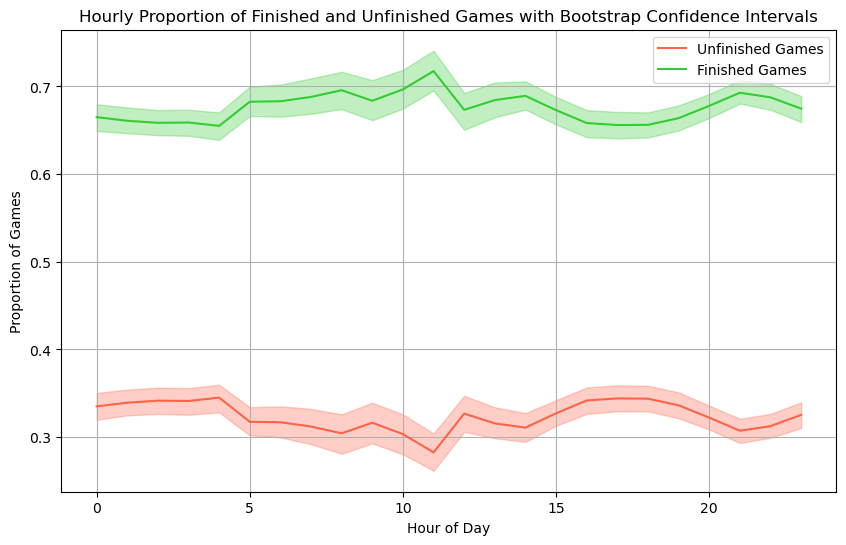

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot proportions for unfinished games
ax.plot(ci_df['hour'], ci_df['proportion_unfinished'], color='tomato', label='Unfinished Games')
# Shaded area for the confidence interval of unfinished games
ax.fill_between(ci_df['hour'], ci_df['ci_lower_unfinished'], ci_df['ci_upper_unfinished'], 
                color='tomato', alpha=0.3)

# Plot proportions for finished games
ax.plot(ci_df['hour'], ci_df['proportion_finished'], color='limegreen', label='Finished Games')
# Shaded area for the confidence interval of finished games
ax.fill_between(ci_df['hour'], ci_df['ci_lower_finished'], ci_df['ci_upper_finished'], 
                color='limegreen', alpha=0.3)

# Labels and title
ax.set_title('Hourly Proportion of Finished and Unfinished Games with Bootstrap Confidence Intervals')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Proportion of Games')
ax.legend()
plt.grid(True)
plt.show()

In [9]:
df_unfinished_t = df_unfinished[df_unfinished['type']=='timeout']
df_unfinished_r = df_unfinished[df_unfinished['type']=='restart']

In [ ]:
# Correlation with hour

# Group data by hour for finished and each quitting type
df_finished_hour = df_finished.groupby('hour').size()
df_unfinished_t_hour = df_unfinished_t.groupby('hour').size()  # Timeout
df_unfinished_r_hour = df_unfinished_r.groupby('hour').size()  # Restart

# Calculate the total games per hour to normalize
total_games_hour = df_finished_hour + df_unfinished_t_hour + df_unfinished_r_hour

# Normalize each type by total games per hour
df_finished_hour_norm = df_finished_hour / total_games_hour
df_unfinished_t_hour_norm = df_unfinished_t_hour / total_games_hour
df_unfinished_r_hour_norm = df_unfinished_r_hour / total_games_hour

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

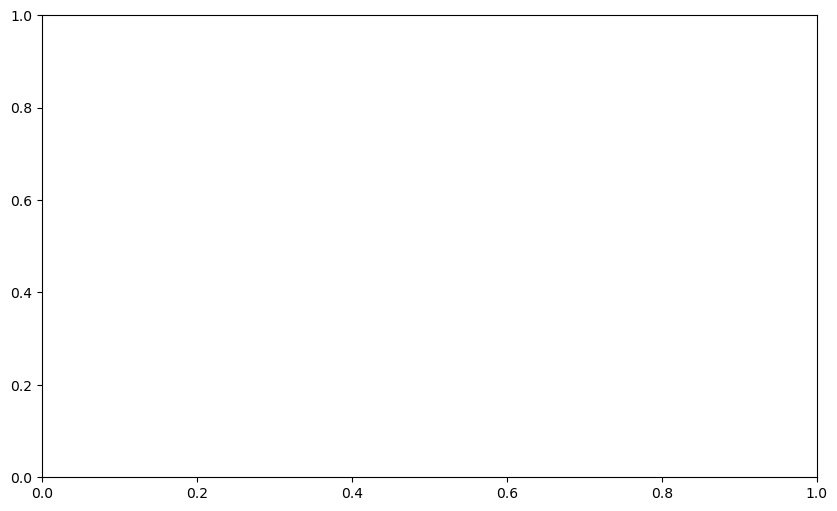

In [ ]:
# Calculate proportions and bootstrap CIs
num_bootstrap_samples = 1000
ci_results = {'timeout': [], 'restart': [], 'finished': []}
hours = df_unfinished_t_hour.index  # assuming hours are the index

for hour in hours:
    # Timeout proportion and CI
    timeout_data = np.repeat(1, df_unfinished_t_hour[hour])
    timeout_prop = df_unfinished_t_hour_norm[hour] 
    timeout_ci = bootstrapping(timeout_data, num_samples=num_bootstrap_samples)
    ci_results['timeout'].append((timeout_prop, timeout_ci))

    # Restart proportion and CI
    restart_data = np.repeat(1, df_unfinished_r_hour[hour])
    restart_prop = df_unfinished_r_hour[hour] / total_games_hour[hour]
    restart_ci = bootstrapping(restart_data, num_samples=num_bootstrap_samples)
    ci_results['restart'].append((restart_prop, restart_ci))

    # Finished proportion and CI
    finished_data = np.repeat(1, df_finished_hour[hour])
    finished_prop = df_finished_hour[hour] / total_games_hour[hour]
    finished_ci = bootstrapping(finished_data, num_samples=num_bootstrap_samples)
    ci_results['finished'].append((finished_prop, finished_ci))

# Prepare data for plotting
timeout_props, timeout_cis = zip(*ci_results['timeout'])
restart_props, restart_cis = zip(*ci_results['restart'])
finished_props, finished_cis = zip(*ci_results['finished'])

# Split CIs into lower and upper bounds
timeout_lower, timeout_upper = zip(*timeout_cis)
restart_lower, restart_upper = zip(*restart_cis)
finished_lower, finished_upper = zip(*finished_cis)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot proportions with error bars for each quitting type
ax.errorbar(hours, timeout_props, yerr=[timeout_props - timeout_lower, timeout_upper - timeout_props], 
            fmt='o-', label='Timeout', color='orange')
ax.errorbar(hours, restart_props, yerr=[restart_props - restart_lower, restart_upper - restart_props], 
            fmt='o-', label='Restart', color='red')
ax.errorbar(hours, finished_props, yerr=[finished_props - finished_lower, finished_upper - finished_props], 
            fmt='o-', label='Finished Games', color='limegreen')

# Labels and title
ax.set_title('Proportion of Finished and Unfinished Games by Hour with Bootstrap Confidence Intervals')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Normalized Proportion of Games')
ax.legend()
plt.grid(True)
plt.show()

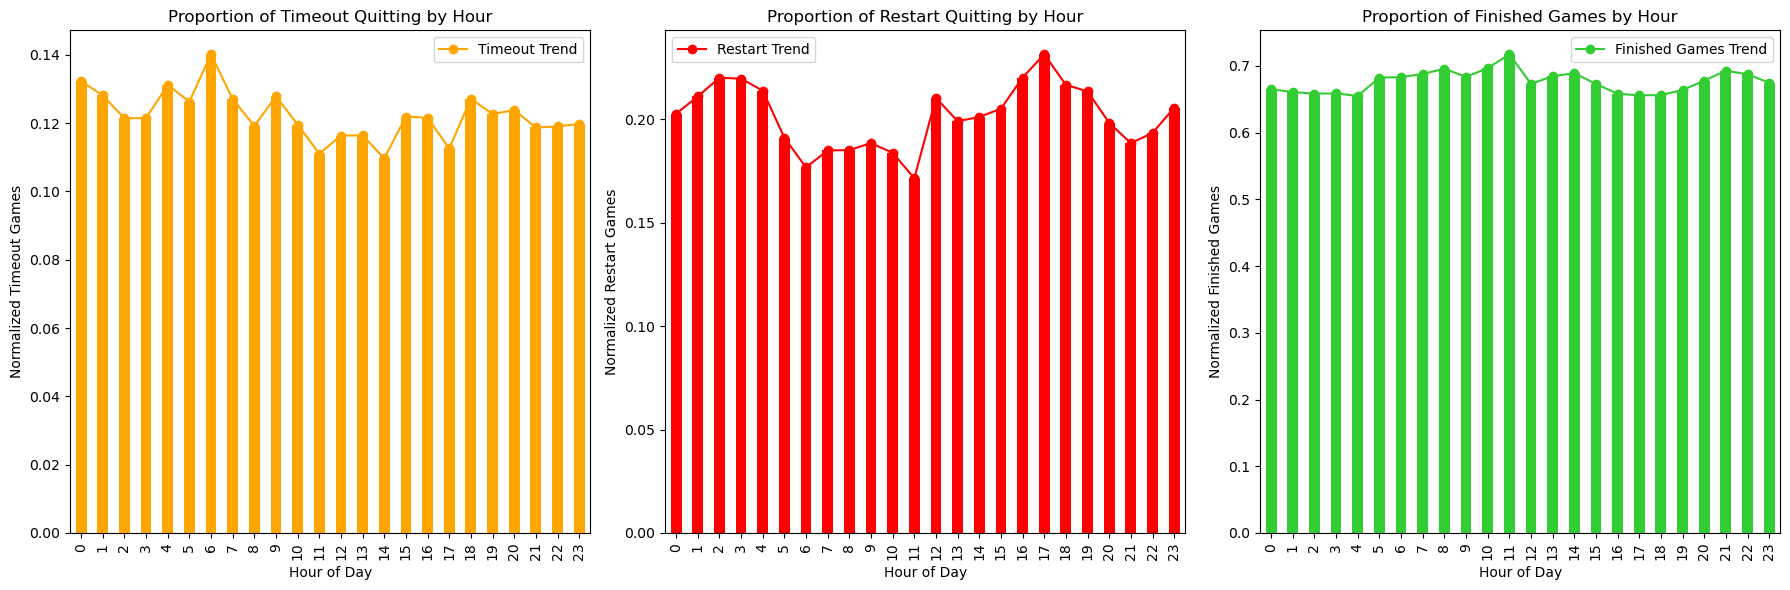

In [12]:
# Plotting
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 6))

# Plot normalized unfinished games (timeout) per hour
df_unfinished_t_hour_norm.plot(kind='bar', color='orange', ax=ax0)
ax0.set_title('Proportion of Timeout Quitting by Hour')
ax0.set_xlabel('Hour of Day')
ax0.set_ylabel('Normalized Timeout Games')
ax0.plot(df_unfinished_t_hour_norm, color='orange', marker='o', linestyle='-', label='Timeout Trend')
ax0.legend()

# Plot normalized unfinished games (restart) per hour
df_unfinished_r_hour_norm.plot(kind='bar', color='red', ax=ax1)
ax1.set_title('Proportion of Restart Quitting by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Normalized Restart Games')
ax1.plot(df_unfinished_r_hour_norm, color='red', marker='o', linestyle='-', label='Restart Trend')
ax1.legend()

# Plot normalized finished games per hour
df_finished_hour_norm.plot(kind='bar', color='limegreen', ax=ax2)
ax2.set_title('Proportion of Finished Games by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Normalized Finished Games')
ax2.plot(df_finished_hour_norm, color='limegreen', marker='o', linestyle='-', label='Finished Games Trend')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'df_unfinished_hour_norm' is not defined

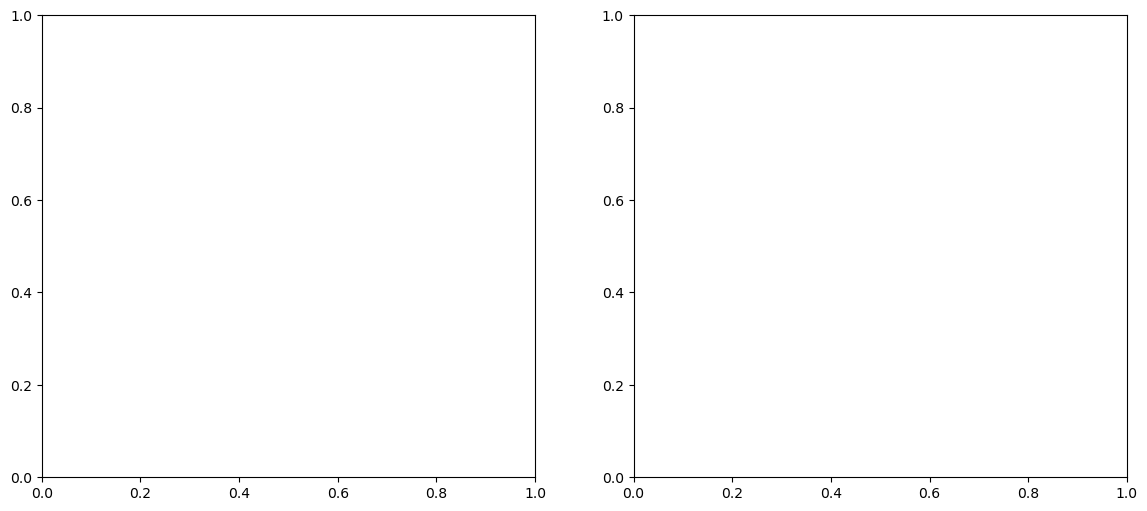

In [11]:
# Barplot for representing relation between proportion of finished and unfinished games vs hours

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

# First subplot: normalized unfinished games barplot
df_unfinished_hour_norm.plot(kind='bar', color='tomato', ax=ax0)
ax0.set_title('Proportion of Unfinished Games by Hour')
ax0.set_xlabel('Hour of day')
ax0.set_ylabel('Normalized unfinished games')
# Add line plot on top of the bar chart to see evolution
ax0.plot(df_unfinished_hour_norm, color='tomato', marker='o', linestyle='-', label='Unfinished games trend')
ax0.legend()

# Second subplot: normalized finished games barplot
df_finished_hour_norm.plot(kind='bar', color='limegreen', ax=ax1)
ax1.set_title('Proportion of Finished Games by Hour')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Normalized finished games')
# Add a line plot 
ax1.plot(df_finished_hour_norm, color='limegreen', marker='o', linestyle='-', label='Finished games trend')
ax1.legend()

plt.tight_layout()
plt.show()

There appears to be no strong correlation between the hour of day and the proportion of unfinished games. Both finished and unfinished games seem relatively stable throughout the day, displaying very small fluctutations that do not follow any meaningful pattern.

**Correlation with thematic**

In [ ]:
# Accessing categories
categories_column_names = ['article','category']
df_categories = pd.read_csv('./dataset/categories.tsv',
                             sep='\t',
                             names = categories_column_names,
                             comment='#') #ignore metadata


In [ ]:
df_unfinished_hour

hour
0     494
1     480
2     449
3     449
4     445
5     366
6     333
7     252
8     204
9     196
10    197
11    191
12    230
13    297
14    344
15    416
16    446
17    444
18    521
19    498
20    560
21    529
22    512
23    470
dtype: int64

In [ ]:
df_unfinished.size

74584

In [ ]:
df_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [ ]:
# Create a contingency table with counts of unfinished and finished games by hour
contingency_table = pd.DataFrame({
    'unfinished': df_unfinished_hour,
    'finished': df_finished_hour
})

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test p-value:", p_value)
# Decision to reject/accept null hypothesis
hypothesis_testing(p_value=p_value)

Chi-Square Test p-value: 0.11295098260118867
Given p value = 0.11295098260118867 is greater than alpha = 0.05, the null hypothesis fails to be rejected.


In [ ]:
# Calculate Spearman correlation
hours = df_unfinished_hour.index  # hours (0-23)
unfinished_proprotion_hour = df_unfinished_hour.values  # normalized counts

correlation, p_value = spearmanr(hours, unfinished_proprotion_hour)
print("Spearman Correlation:", correlation)
print("p-value:", p_value)

Spearman Correlation: 0.33963905999680727
p-value: 0.10442947663388846


In [ ]:
df_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime,hour
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 05:02:15,5
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 05:14:11,5
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 15:00:19,15
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 17:18:25,17
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,2011-02-07 17:42:37,17
